In [1]:
import numpy as np
from mpmath import besseljzero
from scipy.special import gamma
from scipy.special import jv, iv, ive
from scipy.integrate import quad
from scipy.interpolate import interp1d

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVR

import warnings 
warnings.simplefilter('ignore')

In [2]:
def simulate_circular(a, mu, sigma=1, dt=0.001):
    x = np.zeros(mu.shape)
    
    rt = 0
    while np.linalg.norm(x, 2) < a(rt):
        x += mu*dt + sigma*np.sqrt(dt)*np.random.normal(0, 1, mu.shape)
        rt += dt
        
    return rt, np.arctan2(x[1], x[0])

In [3]:
def series_bessel_fpt(t, a=1, sigma=1, nu=0, n=100):
    zeros = np.asarray([float(besseljzero(nu, i+1)) for i in range(n)])
    fpt = np.zeros(t.shape)
    
    for i in range(t.shape[0]):
        series = np.sum((zeros**(nu+1)/jv(nu+1, zeros)) * np.exp(-(zeros**2 * sigma**2)/(2*a**2)*t[i]))
        fpt[i] = sigma**2/(2**nu * a**2 * gamma(nu + 1)) * series
        
    return interp1d(t, fpt)

def series_term(t, a=1, sigma=1, nu=0, n=50):
    zeros = np.asarray([float(besseljzero(nu, i+1)) for i in range(n)])
    
    series = sigma**2/(2**nu * a**2 * gamma(nu + 1)) * zeros**(nu+1)/jv(nu+1, zeros) * np.exp(-(zeros**2 * sigma**2)/(2*a**2)*t)
        
    return np.abs(series)

In [4]:
def girsanov(a, theta, mu, fpt, t, sigma=1):
    term1 = a(t)/sigma**2 * (mu[0]*np.cos(theta) + mu[1]*np.sin(theta))
    term2 = 0.5/sigma**2 * np.linalg.norm(mu, 2)**2 * t
    g = np.exp(term1 - term2) * fpt(t)
    return g

In [5]:
def k(a, da, t, q, sigma=2):
    return 0.5 * (q - 0.5*sigma - da(t))

def psi(a, da, t, z, tau, q, sigma=2):
    kk = k(a, da, t, q, sigma)
    
    if 2*np.sqrt(a(t)*z)/(sigma*(t-tau))<=700:
        term1 = 1./(sigma*(t - tau)) * np.exp(- (a(t) + z)/(sigma*(t-tau)))
        term2 = (a(t)/z)**(0.5*(q-sigma)/sigma)
        term3 = da(t) - (a(t)/(t-tau)) + kk
        term4 = iv(q/sigma-1, 2*np.sqrt(a(t)*z)/(sigma*(t-tau)))
        term5 = (np.sqrt(a(t)*z)/(t-tau)) * iv(q/sigma, 2*np.sqrt(a(t)*z)/(sigma*(t-tau)))
    else:
        term1 = 1./(sigma*(t - tau))
        term2 = (a(t)/z)**(0.5*(q-sigma)/sigma)
        term3 = da(t) - (a(t)/(t-tau)) + kk
        term4 = ive(q/sigma-1, (a(t) + z)/(sigma*(t-tau)))
        term5 = (np.sqrt(a(t)*z)/(t-tau)) * ive(q/sigma, (a(t) + z)/(sigma*(t-tau)))
    
    return term1 * term2 * (term3 * term4 + term5)

def ie_bessel_fpt(a, da, q, z, sigma=2, dt=0.1, T_max=2):
    g = [0]
    T = [0]
    g.append(-2*psi(a, da, dt, z, 0, q, sigma))
    T.append(dt)
    
    for n in range(2, int(T_max/dt)+2):
        s = -2 * psi(a, da, n*dt, z, 0, q, sigma)

        for j in range(1, n):
            if a(j*dt) == 0:
                continue
            
            s += 2 * dt * g[j] * psi(a, da, n*dt, a(j*dt), j*dt, q, sigma)

        g.append(s)
        T.append(n*dt)
        
    g = np.asarray(g)
    T = np.asarray(T)
    
    gt = interp1d(T, g)
    return gt

In [6]:
def marginal_dist(b0, lamb, mu=np.asarray([1, 1]), n_sim=10000):
#     threshold = lambda t: b0*np.exp(-lamb*t)
#     ie_threshold = lambda t: (b0*np.exp(-lamb*t))**2
#     d_ie_threshold = lambda t: -2*lamb*b0*np.exp(-lamb*t) * ie_threshold(t)
    
    threshold = lambda t: b0/(1+lamb*t)
    ie_threshold = lambda t: (b0/(1+lamb*t))**2
    d_ie_threshold = lambda t: -2*lamb*b0/(1 + lamb*t)**2 * ie_threshold(t)
    
#     threshold = lambda t: b0 - lamb*t
#     ie_threshold = lambda t: (threshold(t))**2
#     d_ie_threshold = lambda t: -2*lamb * threshold(t)
    
    nu = (mu.shape[0]-2)/2
    
    simulation_RT = []
    
    for i in range(n_sim):
        rt, theta = simulate_circular(threshold, mu)
        simulation_RT.append(rt)
        
#     T_ie = np.linspace(0, b0/lamb, 2000)
    
    T_ie = np.linspace(0, np.max(simulation_RT), 2000)
    
    gt_zero_drift = ie_bessel_fpt(ie_threshold, d_ie_threshold, 
                                  mu.shape[0], 0.0001, sigma=2, 
                                  dt=0.025, T_max=np.max(simulation_RT))
    
    joint_dens = lambda theta, t: girsanov(threshold, theta, mu, gt_zero_drift, t)
    
    marginal = interp1d(T_ie, [quad(joint_dens, args=(t), a=0, b=2*np.pi)[0] for t in T_ie])
    normalization = quad(marginal, a=T_ie[0], b=T_ie[-1])[0]
    
    return marginal, normalization, simulation_RT, T_ie


In [7]:
marginal1, normalization1, simulation_RT1, T_ie1 = marginal_dist(4, 1) #b_0=4, lambda=1
marginal2, normalization2, simulation_RT2, T_ie2 = marginal_dist(4, 2) #b_0=4, lambda=2
marginal3, normalization3, simulation_RT3, T_ie3 = marginal_dist(4, 3) #b_0=4, lambda=3
marginal4, normalization4, simulation_RT4, T_ie4 = marginal_dist(5, 2) #b_0=5, lambda=2
marginal5, normalization5, simulation_RT5, T_ie5 = marginal_dist(6, 2) #b_0=6, lambda=2
marginal6, normalization6, simulation_RT6, T_ie6 = marginal_dist(7, 2) #b_0=7, lambda=2

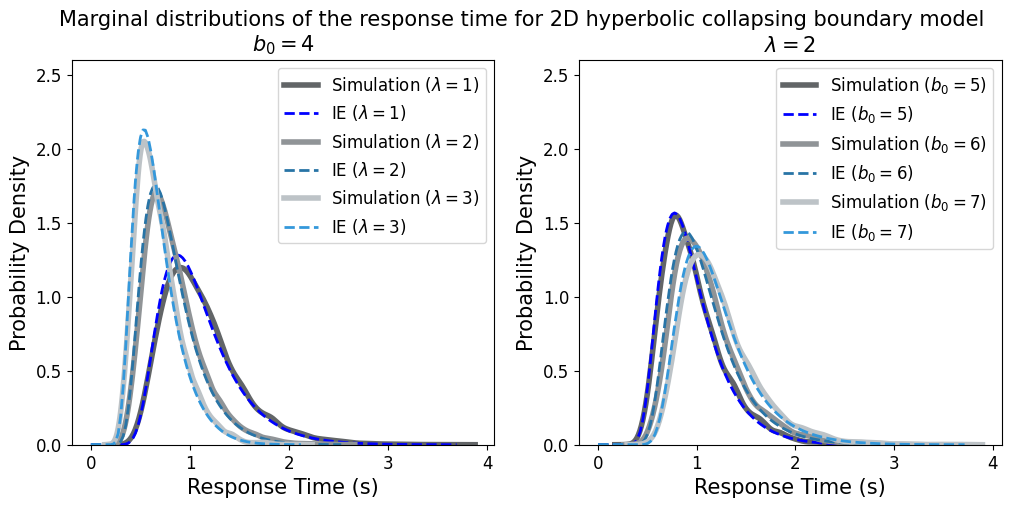

In [8]:
fig = plt.figure(figsize=(12, 5))


plt.rc('font', size=10)          # controls default text sizes
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize

fig.suptitle('Marginal distributions of the response time for 2D hyperbolic collapsing boundary model', fontsize=15)

plt.subplot(121)
plt.title(r'$b_0=4$')
plt.ylim([0, 2.6])
sns.kdeplot(simulation_RT1, c='#626567', linewidth=4, label=r'Simulation ($\lambda=1$)')
plt.plot(T_ie1, marginal1(T_ie1)/normalization1, '--', linewidth=2, c='blue', label=r'IE ($\lambda=1$)');

sns.kdeplot(simulation_RT2, c='#909497', linewidth=4, label=r'Simulation ($\lambda=2$)')
plt.plot(T_ie2, marginal2(T_ie2)/normalization2, '--', linewidth=2, c='#2874a6', label=r'IE ($\lambda=2$)');

sns.kdeplot(simulation_RT3, c='#bdc3c7', linewidth=4, label=r'Simulation ($\lambda=3$)')
plt.plot(T_ie3, marginal3(T_ie3)/normalization3, '--', linewidth=2, c='#3498db', label=r'IE ($\lambda=3$)');
plt.xlabel('Response Time (s)')
plt.ylabel('Probability Density')
plt.legend();


plt.subplot(122)
plt.title(r'$\lambda=2$')
plt.ylim([0, 2.6])
sns.kdeplot(simulation_RT4, c='#626567', linewidth=4, label=r'Simulation ($b_0=5$)')
plt.plot(T_ie4, marginal4(T_ie4)/normalization4, '--', linewidth=2, c='blue', label=r'IE ($b_0=5$)');

sns.kdeplot(simulation_RT5, c='#909497', linewidth=4, label=r'Simulation ($b_0=6$)')
plt.plot(T_ie5, marginal5(T_ie5)/normalization5, '--', linewidth=2, c='#2874a6', label=r'IE ($b_0=6$)');

sns.kdeplot(simulation_RT6, c='#bdc3c7', linewidth=4, label=r'Simulation ($b_0=7$)')
plt.plot(T_ie6, marginal6(T_ie6)/normalization6, '--', linewidth=2, c='#3498db', label=r'IE ($b_0=7$)');
plt.xlabel('Response Time (s)')
plt.ylabel('Probability Density')
plt.legend();

plt.savefig('../../_01_Figures/hyperbolic_collapsing_marginal.pdf', 
            transparent=True, 
            dpi=600, 
            bbox_inches='tight');